<a href="https://www.kaggle.com/code/johnybhiduri/pizza-not-pizza-image-classifier-in-tensorflow?scriptVersionId=113681727" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path
import warnings
warnings.filterwarnings('ignore')

# Setting paths of the files


In [2]:
not_pizza = Path('/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza')
pizza = Path('/kaggle/input/pizza-not-pizza/pizza_not_pizza/pizza')


# Converting path and labels of file a dataframe

In [3]:
not_pizza_filepaths = list(not_pizza.glob('**/*.jpg'))
pizza_filepaths = list(pizza.glob('**/*.jpg'))
not_pizza_labels = list(map(lambda x : 'Not_pizza', not_pizza_filepaths))
not_pizza_filepaths = pd.Series(not_pizza_filepaths , name = 'Filepath').astype(str)
not_pizza_labels = pd.Series(not_pizza_labels, name = 'Label')
not_pizza_df = pd.concat([not_pizza_filepaths, not_pizza_labels], axis = 1)
pizza_labels = list(map(lambda x : 'Pizza', pizza_filepaths))
pizza_filepaths = pd.Series(pizza_filepaths, name = 'Filepath').astype(str)
pizza_labels = pd.Series(pizza_labels, name = 'Label')
pizza_df = pd.concat([pizza_filepaths, pizza_labels], axis = 1)

# Concatinating both dataframe in single dataframe

In [4]:
image_df = pd.concat([pizza_df, not_pizza_df])

In [5]:
image_df

,Filepath,Label
0,/kaggle/input/pizza-not-pizza/pizza_not_pizza/...,Pizza
1,/kaggle/input/pizza-not-pizza/pizza_not_pizza/...,Pizza
2,/kaggle/input/pizza-not-pizza/pizza_not_pizza/...,Pizza
3,/kaggle/input/pizza-not-pizza/pizza_not_pizza/...,Pizza
4,/kaggle/input/pizza-not-pizza/pizza_not_pizza/...,Pizza
...,...,...
978,/kaggle/input/pizza-not-pizza/pizza_not_pizza/...,Not_pizza
979,/kaggle/input/pizza-not-pizza/pizza_not_pizza/...,Not_pizza
980,/kaggle/input/pizza-not-pizza/pizza_not_pizza/...,Not_pizza
981,/kaggle/input/pizza-not-pizza/pizza_not_pizza/...,Not_pizza


# Checking Dupicated Items

In [6]:
image_df.duplicated().sum()

0

# Train Test Splitting

In [7]:
train_df, test_df = train_test_split(image_df, test_size = 0.30, shuffle = True, random_state = 1)

In [8]:
print(len(train_df[train_df['Label'] == 'Pizza']))
len(train_df[train_df['Label'] == 'Not_pizza'])

696


680

# Loading Image Data

In [9]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range = 0.20,
    height_shift_range = 0.20,
    validation_split = 0.20
)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)


In [10]:
train_image = train_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)
val_image = train_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)
test_image = train_gen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False,
)

Found 1101 validated image filenames belonging to 2 classes.
Found 275 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# Trainnig Data

In [22]:
inputs = tf.keras.Input(shape = (224, 224, 3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3),activation = 'relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3),activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs , outputs = outputs)
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)
history = model.fit(
    train_image, validation_data = val_image,
    epochs = 100,
    callbacks = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 6,
        restore_best_weights = True
    )
)

2022-12-13 06:02:56.376699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-13 06:02:59.510414: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


35/35 [==============================] - 44s 905ms/step - loss: 0.6891 - accuracy: 0.5550 - val_loss: 0.6784 - val_accuracy: 0.5382
Epoch 2/100
35/35 [==============================] - 23s 647ms/step - loss: 0.6884 - accuracy: 0.5404 - val_loss: 0.7011 - val_accuracy: 0.4945
Epoch 3/100
35/35 [==============================] - 21s 615ms/step - loss: 0.6820 - accuracy: 0.5577 - val_loss: 0.6734 - val_accuracy: 0.5636
Epoch 4/100
35/35 [==============================] - 22s 628ms/step - loss: 0.6658 - accuracy: 0.5958 - val_loss: 0.6519 - val_accuracy: 0.6109
Epoch 5/100
35/35 [==============================] - 22s 641ms/step - loss: 0.6553 - accuracy: 0.6167 - val_loss: 0.6439 - val_accuracy: 0.6218
Epoch 6/100
35/35 [==============================] - 22s 626ms/step - loss: 0.6469 - accuracy: 0.6122 - val_loss: 0.6499 - val_accuracy: 0.6073
Epoch 7/100
35/35 [==============================] - 21s 612ms/step - loss: 0.6362 - accuracy: 0.6312 - val_loss: 0.6411 - val_accuracy: 0.6327
Epoc

# Results

In [23]:
results = model.evaluate(test_image, verbose = 0)
print(f'Test Loss : {round(results[0], 3)}')
print(f'Test Accuracy : {round(results[1], 4)*100}%')

Test Loss : 0.487
Test Accuracy : 78.14%


# Confusion Matrix and Classification Report

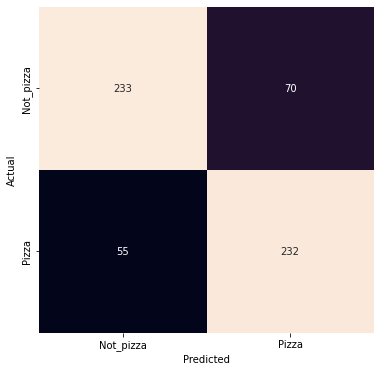

Classification Report------------------------>
              precision    recall  f1-score   support

   Not_pizza       0.81      0.77      0.79       303
       Pizza       0.77      0.81      0.79       287

    accuracy                           0.79       590
   macro avg       0.79      0.79      0.79       590
weighted avg       0.79      0.79      0.79       590



In [24]:
test_image_pred = (model.predict(test_image) >=0.5).astype(np.int)
cm = confusion_matrix(test_image.labels, test_image_pred, labels = [0,1])
clr = classification_report(test_image.labels,test_image_pred, labels = [0 , 1], target_names = ['Not_pizza', 'Pizza'])
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False)
plt.xticks(ticks = [0.5, 1.5], labels = ['Not_pizza', 'Pizza'])
plt.yticks(ticks = [0.5, 1.5], labels = ['Not_pizza', 'Pizza'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'Classification Report------------------------>\n{clr}')